<a href="https://colab.research.google.com/github/angiellanos/Merton_con_procesos_difusi-n_con_saltos/blob/main/Modelos_de_Merton_con_saltos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MODELOS DE MERTON CON PROCESOS DE DIFUSIÓN CON SALTOS**
## **Universidad Nacional de Colombia**
# Derivados de Renta Variable
---
Elaborado por:
###Angie Eloisa Llanos
###Brayan Arturo Camargo
###Camilo Andres Figueroa
---



# 1. **Introducción**

Este modelo financiero avanzado para la valoración de opciones integra procesos de Poisson y movimiento Browniano para capturar con mayor precisión las fluctuaciones extremas del mercado. A diferencia de los modelos tradicionales, este enfoque aborda las anomalías estadísticas como sesgo y exceso de curtosis en los rendimientos. Utilizamos datos históricos del índice MSCI COLCAP, que incluye algunas de las acciones más representativas del mercado colombiano, del período del **15 de junio del 2021** al **14 de junio de 2024**. El objetivo es calcular el precio de una opción europea de compra sobre este índice, explorando varios precios de ejercicio (strikes) y tiempos de madurez. Esta metodología mejora la gestión de riesgos financieros y la evaluación se realizará con un enfoque empírico, ofreciendo una perspectiva más realista del comportamiento de los activos en mercados emergentes.



In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm

# URL PARA 1 AÑO:
# url = 'https://raw.githubusercontent.com/angiellanos/Merton_con_procesos_difusi-n_con_saltos/main/MSCI_COLCAP_20240615_1A.csv'

# URL PARA 3 AÑOS:
url = 'https://raw.githubusercontent.com/angiellanos/Merton_con_procesos_difusi-n_con_saltos/main/MSCI_COLCAP_20240615_3A.csv'

data = pd.read_csv(url, delimiter=';')
print(data.head())

        Fecha Valor hoy Valor ayer  Variación absoluta Variación porcentual  \
0  15/06/2021  1,252.27   1,261.61               -9.34               -0.74%   
1  16/06/2021  1,250.78   1,252.27               -1.49               -0.12%   
2  17/06/2021  1,248.79   1,250.78               -1.99               -0.16%   
3  18/06/2021  1,257.29   1,248.79                8.50                0.68%   
4  21/06/2021  1,246.44   1,257.29              -10.85               -0.86%   

   Variación 12 meses  Variación año  
0                8.45         -12.90  
1                9.78         -13.01  
2                9.63         -13.15  
3                8.25         -12.56  
4                9.02         -13.31  


###Como se va a utilizar únicamente los precios del índice se toma el dataframe solo con la columna de precios y se genera la columna de los rendimientos.

In [ ]:
data = data.iloc[:, :2]

data['Valor hoy'] = data['Valor hoy'].replace(',', '', regex=True).astype(float)
data['Retornos'] = np.log(data['Valor hoy'] / data['Valor hoy'].shift(1))

# volver la columna Fecha a la columna de índices y el nombre de la columna Valor hoy cambie ese nombre a Precios
data = data.set_index('Fecha').rename(columns={'Valor hoy': 'Precios'})

print(data.head())

            Precios  Retornos
Fecha                        
15/06/2021  1252.27       NaN
16/06/2021  1250.78 -0.001191
17/06/2021  1248.79 -0.001592
18/06/2021  1257.29  0.006784
21/06/2021  1246.44 -0.008667




---


### Comportamiento del precio diario del índice MSCI COLCAP

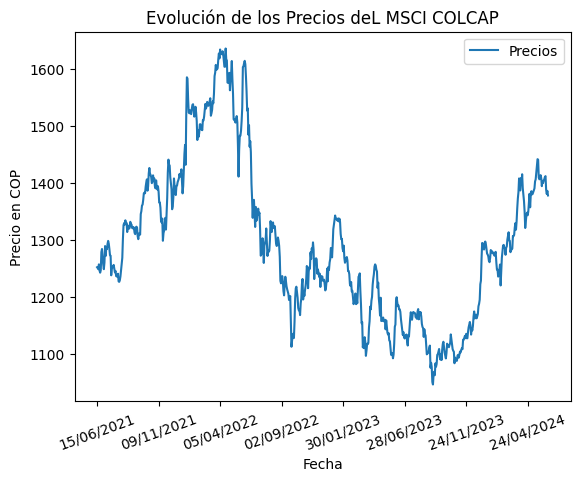

In [ ]:
ax = data.plot(y='Precios')
ax.set_title('Evolución de los Precios deL MSCI COLCAP')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio en COP')
plt.xticks(rotation=20)
plt.show()

###Se observa una tendencia general al alza con varias fluctuaciones significativas en el camino. Este tipo de tendencia es típico en mercados que están experimentando un crecimiento o recuperación, pero también muestra volatilidad, indicando cambios potencialmente significativos en las condiciones del mercado o respuestas a eventos económicos externos. Estas fluctuaciones brindan un escenario ideal para la implementación del modelo, ya que este puede ajustarse para reflejar no solo las tendencias de crecimiento sino también los saltos significativos que no siguen una distribución normal.




---



### Rendimientos logarítmicos diarios deL MSCI COLCAP

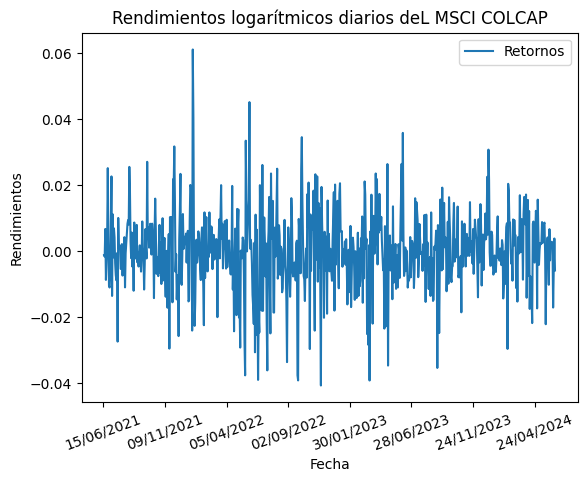

In [ ]:
ax = data.plot(y='Retornos')
ax.set_title('Rendimientos logarítmicos diarios deL MSCI COLCAP')
ax.set_xlabel('Fecha')
ax.set_ylabel('Rendimientos')
plt.xticks(rotation=20)
plt.show()

###Estosos rendimientos logarítmicos diarios oscilan alrededor de cero con algunos picos significativos en ambas direcciones. Estos picos indican días con movimientos de precios anormalmente altos o bajos, posiblemente debidos a noticias del mercado o cambios económicos.



---

### Distribución empírica normalizada del rendimiento logarítmico diario del índice MSCI COLCAP y la distribución normal.

In [ ]:
# Borrar el primer elemento que da nulo, y comprobar que solo elimine ese
print(len(data))
data = data.dropna()
print(len(data))
print(data.head())

733
733
            Precios  Retornos
Fecha                        
16/06/2021  1250.78 -0.001191
17/06/2021  1248.79 -0.001592
18/06/2021  1257.29  0.006784
21/06/2021  1246.44 -0.008667
22/06/2021  1242.70 -0.003005


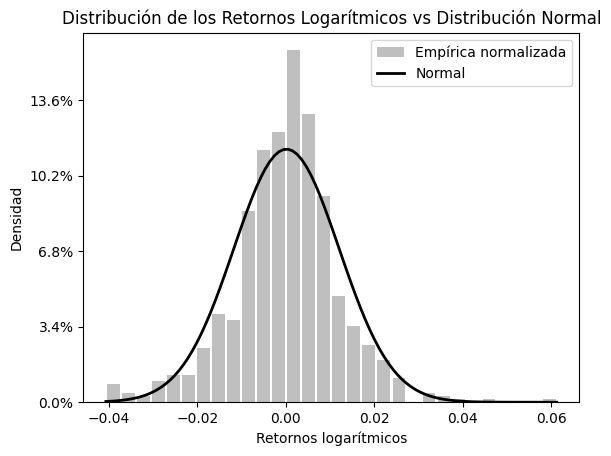

In [ ]:
# Histograma de los retornos logarítmicos
counts, bins, patches = plt.hist(data['Retornos'], bins=30, density=True, alpha=0.5, color='grey', label='Empírica normalizada', rwidth=0.85)

# Calcular la media y desviación estándar de los retornos logarítmicos
mu, std = norm.fit(data['Retornos'])

# Crear un rango de valores que cubre todas las barras del histograma
x = np.linspace(bins[0], bins[-1], 100)

# Calcular la distribución normal con la media y desviación estándar calculadas
p = norm.pdf(x, mu, std)

# Graficar la distribución normal
plt.plot(x, p, 'k', linewidth=2, label='Normal')

# Ajustar las etiquetas del eje Y para mostrar porcentajes
bin_widths = np.diff(bins)
y_vals = plt.gca().get_yticks()
new_labels = ['{:.1%}'.format(y * bin_widths.mean()) for y in y_vals]
plt.gca().set_yticklabels(new_labels)

# Añadir etiquetas y leyenda
plt.title('Distribución de los Retornos Logarítmicos vs Distribución Normal')
plt.xlabel('Retornos logarítmicos')
plt.ylabel('Densidad')
plt.legend()
plt.show()


### Se observa que la distribución empírica exhibe una cresta más marcada y colas más pesadas en comparación con la distribución normal estándar. Esto sugiere que los rendimientos del índice experimentan variaciones más extremas que las esperadas bajo la suposición de normalidad.



---

### Gráfica Q - Q del rendimiento logarítmico diario del índice MSCI COLCAP

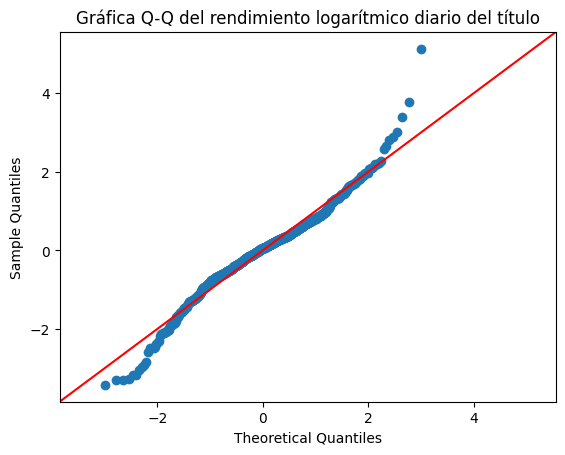

In [ ]:
sm.qqplot(data['Retornos'], line ='45', fit=True)
plt.title('Gráfica Q-Q del rendimiento logarítmico diario del título')
plt.show()

###  Esta gráfica refuerza rendimientos no normales al proporcionar una visualización directa de cómo los cuantiles de los datos reales se desvían de aquellos esperados bajo una distribución normal. En particular, los extremos de la gráfica muestran una desviación significativa de la línea teórica, lo que indica la presencia de colas más pesadas. Estas desviaciones son críticas ya que sugieren que eventos extremos son más probables de lo que la distribución normal puede predecir, un aspecto importante a considerar en la gestión de riesgos y en la modelación financiera.



---

### Diferencia entre la distribución acumulada de los rendimientos logarítmicos diarios del índice MSCI COLCAP y la distribución normal estándar.

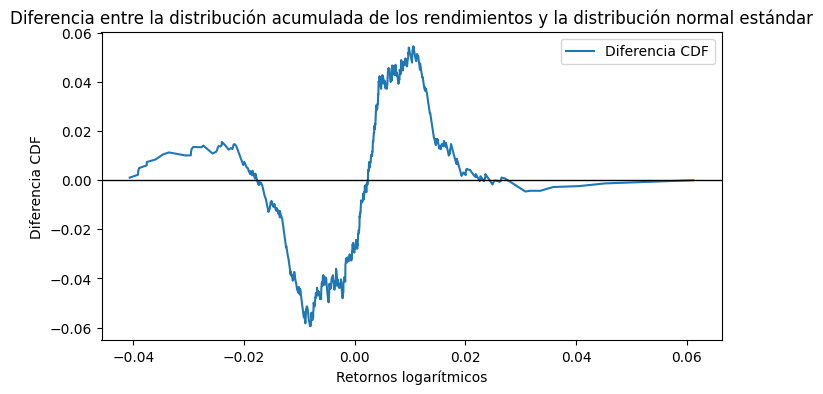

In [ ]:
# Ordena los datos y calcula su CDF empírico
sorted_data = np.sort(data['Retornos'])
cdf_empirical = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Calcula el CDF de una distribución normal estándar con la misma media y desviación estándar que los datos
norm_cdf = norm.cdf(sorted_data, np.mean(sorted_data), np.std(sorted_data))

# Diferencia entre el CDF empírico y el CDF teórico
diff_cdf = cdf_empirical - norm_cdf

# Graficar la diferencia
plt.figure(figsize=(8, 4))
plt.plot(sorted_data, diff_cdf, label='Diferencia CDF')
plt.axhline(0, color='black', linewidth=1)
plt.title('Diferencia entre la distribución acumulada de los rendimientos y la distribución normal estándar')
plt.xlabel('Retornos logarítmicos')
plt.ylabel('Diferencia CDF')
plt.legend()
plt.show()


### Se observa una variabilidad considerable alrededor del origen y desviaciones a lo largo de todo el rango de los datos. Esto corrobora que los rendimientos del MSCI COLCAP no siguen una distribución normal, implicando que el uso de modelos estándar basados en supuestos de normalidad podría no ser adecuado.